In [9]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim

In [11]:
path = "../hand_labeled/"
datalist = ['DCM', 'DIT', 'IRS']

output = "./"

import spacy
nlp = spacy.load('ja_ginza')
emb_dim = nlp("形態素").vector.shape[0]
emb_dim

300

In [12]:
def read_json_with_NoErr(path:str, datalist:list) -> pd.DataFrame:
    cols = ['did', 'tid', 'usr', 'sys', 'ec']
    df = pd.DataFrame(index=[], columns=cols)

    for p in datalist:
        datapath = Path(path + p + '/')
        for file in datapath.glob("*.json"):
            with open(file, "r") as f:
                json_data = json.load(f)
                did = json_data["did"]
                for t in json_data["turns"]:
                    if t["turn-index"] == 0:
                        continue
                    if t["speaker"] == "U":
                        usr = t["utterance"]
                        continue
                    if t["speaker"] == "S" :
                        tid = t["turn-index"]
                        sys = t["utterance"]
                        if t["error_category"]:
                            ec = t["error_category"]
                        else:
                            ec = ["No-Err"]
                        df = df.append(pd.DataFrame([did, tid, usr, sys, ec], index = cols).T)
    df.reset_index(inplace=True, drop=True)
    return df

def extract_error(df, errors):
    utterances = []
    for d, u, s, e in zip(df.did, df.usr, df.sys, df.ec):
        for err in errors:
            if err in e:
                utterances.append([u, s])
    return utterances

def no_error(df):
    utterances = []
    system = []
    user = []
    for d, u, s, e in zip(df.did, df.usr, df.sys, df.ec):
        if e[0] == "No-Err":
            utterances.append([ u, s])
        # system.append(s)
        # user.append(u)
    return utterances

def _in(arg1, arg2):
    result = False
    if isinstance(arg1, list):
        for element in arg1:
            if isinstance(element, str):
                if element in arg2:
                    result = True
                    break
            else:
                if element == arg2:
                    result = True
                    break
    else:
        if isinstance(arg1, str):
            if arg1 in arg2:
                result = True
        else:
            if arg1 == arg2:
                result = True
    return result

def filter_pos_vector(pos_list, text):
    vec = np.zeros(emb_dim)
    doc = nlp(text, disable=['ner'])
    for token in doc:
        # print(token, token.tag_)
        if "助動詞" not in token.tag_ and _in(pos_list, token.tag_):
            # print(token, token.tag_)
            vec += token.vector
    return vec

def feature_extraction(pos_list, convs, mode, is_norm=False):
    feature_list = []
    for utt in convs:

        if mode == "dif":
            usr_vec = filter_pos_vector(pos_list, utt[0] )
            sys_vec = filter_pos_vector(pos_list, utt[1] )
            dif_vec = usr_vec - sys_vec
            # if np.linalg.norm(dif_vec)==0:
            #     print(utt)
            if is_norm:
                # print(np.linalg.norm(dif_vec))
                if np.linalg.norm(dif_vec)==0:
                    vec = np.concatenate( [dif_vec, dif_vec/0.05] )
                else:
                    vec = np.concatenate( [dif_vec, dif_vec/np.linalg.norm(dif_vec)] )
                feature_list.append(vec)
            else:
                feature_list.append(dif_vec)
    
    return np.array(feature_list, dtype="float32")


def remove_norm_zero(pos_list, convs):
    convs_removed = []
    for utt in convs:
        usr_vec = filter_pos_vector(pos_list, utt[0] )
        sys_vec = filter_pos_vector(pos_list, utt[1] )
        dif_vec = usr_vec - sys_vec
        if np.linalg.norm(dif_vec)==0 or np.linalg.norm(usr_vec)==0 or np.linalg.norm(sys_vec)==0:
            continue
        convs_removed.append(utt)
    return convs_removed

In [13]:
df = read_json_with_NoErr(path, datalist)

In [14]:
errors = ["Topic transition error", "Unclear intention", "Lack of information"]
errors = ["Topic transition error"]
ut = extract_error(df, errors)
ut_no = no_error(df)

In [15]:

pos_list = ["名詞", "動詞", "形状詞", "形容詞"]
ut_new = remove_norm_zero(pos_list, ut)
ut_no_new = remove_norm_zero(pos_list, ut_no)

In [16]:
import random
def fake_error(convs, times):
    user_list = []
    system_list = []
    for utt in convs:
        user_list.append(utt[0])
        system_list.append(utt[1])
    
    fake_convs = []
    for _ in range(times):
        fake_convs.append( [random.choice(user_list), random.choice(system_list)] )
    return fake_convs

In [17]:
UT = ut_new + fake_error(ut_no_new, len(ut_no_new)-len(ut_new))
UT_NO = ut_no_new
print("UT: {0}".format(len(UT)))
print("UT_NO: {0}".format(len(UT_NO)))

UT: 528
UT_NO: 528


In [18]:
# LSTM?
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size, batch_size):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        # LSTMの隠れ層。これ１つでOK。超便利。
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        # self.softmax = 
    
    def forward(self, x):
        #embeds.size() = (batch_size × len(sentence) × embedding_dim)
        batch_size, seq_len = x.shape[0], x.shape[1]
        _, hidden_layer = self.lstm(x)
        # print(hidden_layer)
        y = self.hidden2tag(hidden_layer[0].view(batch_size, -1))
        y = F.log_softmax(y, dim=1)
        return y

In [19]:
len_func = lambda conv: sum( [ len(nlp(c)) for c in conv] )
max_len = max( list(map(len_func, UT+UT_NO)) )
print(max_len)

84


In [20]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [21]:
def make_X(convs, max_len):
    emb_dim = nlp("形態素").vector.shape
    X_data = []
    for conv in convs:
        vec_list = np.zeros( (max_len, emb_dim[0]) )
        doc = nlp(conv[0]+conv[1])
        for i, token in enumerate(doc):
            vec_list[i] = token.vector
        X_data.append(vec_list)
    
    return np.array(X_data)

In [69]:
import torch.nn.utils.rnn as rnn
def make_X2(convs):
    emb_dim = nlp("形態素").vector.shape
    X_data = []
    for conv in convs:
        vec_list = []
        doc = nlp(conv[0]+conv[1])
        for i, token in enumerate(doc):
            if np.linalg.norm(token.vector) > 0:
                vec_list.append(token.vector)
        X_data.append( torch.Tensor(vec_list) )
    return rnn.pad_sequence( X_data, batch_first=True)

In [22]:
EMBEDDING_DIM = emb_dim
HIDDEN_DIM = emb_dim*2
OUTPUT_DIM = 2
seq_len = max_len

In [23]:
def y_2array(y_):
    ary = []
    for a in y_:
        b = np.zeros(OUTPUT_DIM)
        b[int(a)] = 1
        ary.append(b)
    return np.array(ary)
y_ = np.concatenate( [ np.ones(len(UT)), np.zeros(len(UT_NO)) ] )


In [70]:

# X = make_X(UT + UT_NO, max_len)
X = make_X2(UT + UT_NO)
# y = y_2array(y_)
y = y_

In [91]:
# y = y_2array(y_)
# y
data_path = "../X_y_data/context/"
data_name = "topic1.pickle"
dataM = DataManager(data_path)

In [93]:
if dataM.is_exist(data_name):
    
    DATA_Xy = dataM.load_data(data_name)
    X = DATA_Xy[0]
    y = DATA_Xy[1]
else:
    # X_data, y_data = pre.extract_X_y(df, error_types, seq_len)
    X = make_X2(UT + UT_NO)
    y = np.concatenate( [ np.ones(len(UT)), np.zeros(len(UT_NO)) ] )
    dataM.save_data(data_name, [X, y])

success save : ../X_y_data/context/topic1.pickle


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [76]:
X_train = X_train[:-4]
y_train = y_train[:-4]
leng = len(y_train)
print(leng)
for i, v in enumerate(y_train):
    if leng %(i+1) == 0:
        print(i+1, end=", ")

840
1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 20, 21, 24, 28, 30, 35, 40, 42, 56, 60, 70, 84, 105, 120, 140, 168, 210, 280, 420, 840, 

In [77]:
BATCH_SIZE = 70
epoch_ = 1000
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [78]:
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [79]:
losses = []
loss_border = 0.0001
# print("error[{0}]".format(error_types[error_i]))
for epoch in range(epoch_):  # again, normally you would NOT do 300 epochs, it is toy data
    all_loss = 0
    for data in trainloader:
        X_t_tensor = torch.tensor(data[0], device='cuda:0').float()
        # y_t_tensor = torch.tensor(data[1].reshape(batch_size, 1), device='cuda:0').float()
        y_t_tensor = torch.tensor(data[1], device='cuda:0').long()
        optimizer.zero_grad()
        model.zero_grad()
        # print(X_t_tensor.shape)

        score = model(X_t_tensor)
        loss_ = loss_function(score, y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 50 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
    # if all_loss <= loss_border:
    #     print("loss was under border(={0}) : train end".format(loss_border))
    #     break
print("done")

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


epoch 50 	 loss 8.334972858428955
epoch 100 	 loss 8.445462048053741
epoch 150 	 loss 8.28945130109787
epoch 200 	 loss 8.261108100414276
epoch 250 	 loss 8.235379099845886
epoch 300 	 loss 8.307891368865967
epoch 350 	 loss 8.31636780500412
epoch 400 	 loss 8.321036040782928
epoch 450 	 loss 8.323181986808777
epoch 500 	 loss 8.320523262023926
epoch 550 	 loss 8.323448777198792
epoch 600 	 loss 8.317480564117432
epoch 650 	 loss 8.317037403583527
epoch 700 	 loss 8.3756964802742
epoch 750 	 loss 8.287786841392517
epoch 800 	 loss 6.3947300016880035
epoch 850 	 loss 1.1349189970642328
epoch 900 	 loss 0.8445930164307356
epoch 950 	 loss 0.11301109043415636
epoch 1000 	 loss 0.0023977498058229685
done


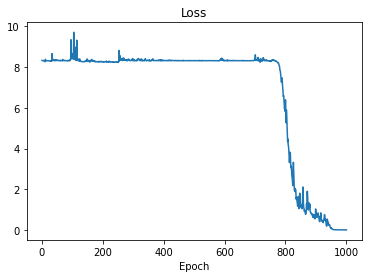

In [80]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [81]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0').float()
    y_tensor = torch.tensor(y_test, dtype=torch.long, device='cuda:0')
            # 推論
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [82]:
metrics.accuracy_score(y_test, y_pred)

0.44339622641509435

In [83]:
y_test

array([1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 1.])

In [89]:
import pickle
class DataManager:
    def __init__(self, data_path) -> None:
        import os
        import pickle
        self.data_path = data_path
        os.makedirs(data_path, exist_ok=True)
        self.dir = os.listdir(data_path)

    def is_exist(self, name):
        return (name in self.dir)
    
    def save_data(self, name, obj):
        with open(self.data_path+name, "wb") as f:
            pickle.dump(obj, f)
        print("success save : {0}{1}".format(self.data_path, name))

    def load_data(self, name):
        with open(self.data_path+name, "rb") as f:
            obj = pickle.load(f)
        print("success load : {0}{1}".format(self.data_path, name))
        return obj



In [87]:
model_path = "../models/context/"
model_name = "topic.pickle"
modelM = DataManager(model_path)

In [90]:
modelM.save_data(model_name, model)

success save : ../models/context/topic.pickle
